Erstmal alle Imports klären:

In [ ]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import glob
import os 

from utils import euklidean_distance

Alle Funktionen die nicht im Maincode gebraucht werden:

In [ ]:

def create_polygon(polygon_coords=list):
    return Polygon(polygon_coords)

def create_point(x, y):
    return Point(x, y)

def is_point_in_polygon(polygon, point):
    return polygon.contains(point)

Feste Variablen:

In [55]:
arena_coords = [(110,20), (1870,25), (1860,1070), (110,1070)]
enter_zone_coords = [(1700,430),(1900,430),(1900,670),(1700,670)]

Ordner mit H5 Dateien wird eingelesen:

In [56]:
path = r"C:\Users\quicken\Code\Ambros_analysis\code_test"
file_list = glob.glob(os.path.join(path, '*.h5'))

df_list = [pd.read_hdf(f) for f in file_list]

scorer_list = [df.columns.levels[0][0] for df in df_list]
individuals_list = [df.columns.levels[1].to_list() for df in df_list]
bodyparts_list = [df.columns.levels[2].to_list() for df in df_list]


In [57]:
test_df = df_list[-1]
test_df = test_df.interpolate("linear", limit=30)
scorer = scorer_list[-1]
bodyparts = bodyparts_list[-1]
individuals = individuals_list[-1]

#for ind 1

arr_x = test_df.loc[:, (scorer, individuals[0], bodyparts, ["x", "y"])].values[:,::2]
arr_y = test_df.loc[:, (scorer, individuals[0], bodyparts, ["x", "y"])].values[:,1::2]

mean_x = np.nanmean(arr_x, axis=1)
mean_y = np.nanmean(arr_y, axis=1)

mouse_center = []

for i in range(len(mean_x)):
    point = (mean_x[i], mean_y[i])
    mouse_center.append(point)



C:\Users\quicken\AppData\Local\Temp\ipykernel_25412\908338825.py:12: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(arr_x, axis=1)
C:\Users\quicken\AppData\Local\Temp\ipykernel_25412\908338825.py:13: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(arr_y, axis=1)


In [58]:
enter_zone_polygon = create_polygon(enter_zone_coords)
arena_polygon = create_polygon(arena_coords)
mouse_in_enter_zone = np.zeros(len(mouse_center))
mouse_in_arena = np.zeros(len(mouse_center))

# iterates over all frames
for i in range(len(mouse_center)):

    # creats a point out of the mouse center coordinates
    center_point = create_point(mouse_center[i][0], mouse_center[i][1])

    # checks, if mouse center is in enter zone and in arena
    if is_point_in_polygon(polygon=enter_zone_polygon, point=center_point):
        mouse_in_enter_zone[i] = 1
    if is_point_in_polygon(polygon=arena_polygon, point=center_point):
        mouse_in_arena[i] = 1




In [59]:
testpoint = Point(654,744)
print(is_point_in_polygon(polygon=arena_polygon, point=testpoint))
print(arena_polygon)

True
POLYGON ((110 20, 1870 25, 1860 1070, 110 1070, 110 20))


In [60]:

# Arrays in bool umwandeln (0/1 -> False/True)
ez = mouse_in_enter_zone.astype(bool)
ar = mouse_in_arena.astype(bool)

n = len(ez)

# Hilfsfunktionen/Arrays
prev_ez = np.pad(ez[:-1], (1, 0), constant_values=False)  # enter_zone im Frame i-1
prev_ar = np.pad(ar[:-1], (1, 0), constant_values=False)  # arena im Frame i-1

# Übergänge (mit Padding, damit Länge n bleibt)
ez_enter = np.pad(ez[1:] & ~ez[:-1], (1, 0), constant_values=False)  # 0->1
ez_exit  = np.pad(~ez[1:] & ez[:-1], (1, 0), constant_values=False)  # 1->0
ar_enter = np.pad(ar[1:] & ~ar[:-1], (1, 0), constant_values=False)  # 0->1
ar_exit  = np.pad(~ar[1:] & ar[:-1], (1, 0), constant_values=False)  # 1->0

# Optional: robuster Lookback auf enter_zone (letzte k Frames vor i)
k = 10  # kannst du anpassen oder auf 1 setzen, wenn nur i-1 zählen soll
was_in_ez_recent = np.zeros(n, dtype=bool)
if k > 0:
    # rolling "any" über letzte k Frames vor i (exklusiv i)
    for shift in range(1, k+1):
        was_in_ez_recent |= np.pad(ez[:-shift], (shift, 0), constant_values=False)

# 1) arena_entry: Maus betritt enter_zone, war davor nicht in arena
arena_entry = ez_enter & (~prev_ar)

# 2) arena_exit: Maus verlässt enter_zone, war davor in arena und ist jetzt nicht mehr in arena
#    -> enter_zone 1->0, ar von True -> False
arena_exit = ez_exit & prev_ar & (~ar)

# 3) id_switch (erscheint in arena ohne zuvor in enter_zone gewesen zu sein)
#    -> arena 0->1, und in den letzten k Frames nicht in enter_zone
id_switch_appear = ar_enter & (~was_in_ez_recent)

# 4) id_switch (verlässt arena, ohne dabei enter_zone zu betreten)
#    -> arena 1->0, und aktuell nicht in enter_zone (optional: auch zuletzt nicht)
id_switch_leave = ar_exit & (~ez) & (~was_in_ez_recent)

# Indizes der Events
idx_arena_entry       = np.where(arena_entry)[0]
idx_arena_exit        = np.where(arena_exit)[0]
idx_id_switch_appear  = np.where(id_switch_appear)[0]
idx_id_switch_leave   = np.where(id_switch_leave)[0]

print("arena_entry @", idx_arena_entry)
print("arena_exit  @", idx_arena_exit)
print("id_switch (appear) @", idx_id_switch_appear)
print("id_switch (leave)  @", idx_id_switch_leave)

arena_entry @ [  36  136 1096 9269]
arena_exit  @ []
id_switch (appear) @ []
id_switch (leave)  @ []


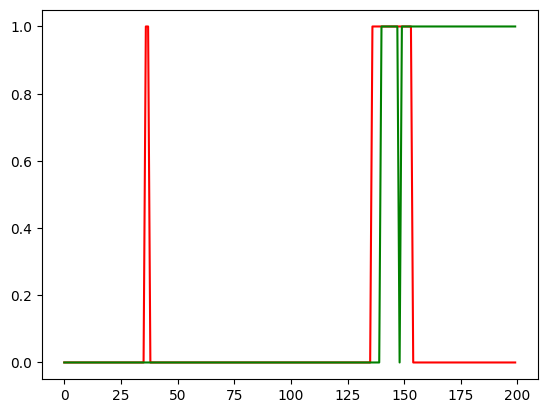

In [64]:
import matplotlib.pyplot as plt

plt.plot(mouse_in_enter_zone[0:200], color='red')
plt.plot(mouse_in_arena[0:200], color = 'green')